1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np

n = int(50001)

file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)

df = pd.DataFrame(data)
subset = df.iloc[0:n]
subset

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49996,1,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,1,0,32,3869200664,1191,1
49999,1,0,60,3869200664,1190,6


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
mask = subset['BX_COUNTER'] == 0
min_indeces = subset[mask].index
#print('\nThe indeces for which BX_COUNTER is zero are: \n', min_indeces)

max_indeces = min_indeces - 1
maximum_BX = subset.loc[max_indeces, 'BX_COUNTER']
#print('\nThe values of BX before the reset to zero are:\n', maximum_BX)
#print('\nThe maximum among them is: \n', np.max(maximum_BX))

x = np.max(maximum_BX) + 1
print('The expected number of BX in ORBIT is: ', x)


The expected number of BX in ORBIT is:  3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [4]:
subset['ABSOLUTE TIME [ns]'] = subset['TDC_MEAS']*25/30 + subset['BX_COUNTER']*25 + subset['ORBIT_CNT']*x*25
first_time = subset.loc[0, 'ABSOLUTE TIME [ns]']


subset['ABSOLUTE TIME [ns]'] = subset['ABSOLUTE TIME [ns]'] - first_time
subset


/var/folders/gk/x5js395j2q5g485hthdhw0l80000gn/T/ipykernel_32724/1500992376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ABSOLUTE TIME [ns]'] = subset['TDC_MEAS']*25/30 + subset['BX_COUNTER']*25 + subset['ORBIT_CNT']*x*25
/var/folders/gk/x5js395j2q5g485hthdhw0l80000gn/T/ipykernel_32724/1500992376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ABSOLUTE TIME [ns]'] = subset['ABSOLUTE TIME [ns]'] - first_time


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE TIME [ns]
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
49996,1,1,4,3869200664,1105,14,4.425096e+07
49997,1,0,59,3869200664,1191,17,4.425312e+07
49998,1,0,32,3869200664,1191,1,4.425310e+07
49999,1,0,60,3869200664,1190,6,4.425308e+07


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
higher_absolute = np.max(subset['ABSOLUTE TIME [ns]'])
print(higher_absolute)
print(pd.to_timedelta(higher_absolute, unit='ns'))

44253225.8125
0 days 00:00:00.044253225


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
ranking = subset.groupby('TDC_CHANNEL').count()['HEAD']
sorted_ranking = ranking.sort_values(ascending=False)
most_noisy = sorted_ranking.iloc[0:3]


for channel, amount in zip(most_noisy.index, most_noisy.values):
    print('Channel number: ', channel, ' ----->', amount, ' times')


Channel number:  139  -----> 4175  times
Channel number:  64  -----> 2523  times
Channel number:  63  -----> 2473  times


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [10]:
non_empty_orbits = len(np.unique(subset['ORBIT_CNT']))
print('The number of non-empty orbits is: ', non_empty_orbits)

The number of non-empty orbits is:  498


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
channels = subset.groupby('TDC_CHANNEL')
group_139 = len(np.unique(channels.get_group(139)['ORBIT_CNT']))
print('The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is: ', group_139)

The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is:  498


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [11]:
fpgas = subset.groupby('FPGA')
fpga_0 = fpgas.get_group(0)
fpga_1 = fpgas.get_group(1)

tdc_channels_0 = fpga_0['TDC_CHANNEL'].values
tdc_channels_1 = fpga_1['TDC_CHANNEL'].values

channels_0 = {}
for channel in tdc_channels_0:
    if channel in channels_0:
        channels_0[channel] = channels_0[channel] + 1
    else:
        channels_0[channel] = 1
channels_0 = sorted(channels_0.items(), key = lambda x: x[0], reverse = False)

channels_1 = {}
for channel in tdc_channels_1:
    if channel in channels_1:
        channels_1[channel] = channels_1[channel] + 1
    else:
        channels_1[channel] = 1
channels_1 = sorted(channels_1.items(), key = lambda x: x[0], reverse = False)

id_channel0 = []
number_count0 = []
for channel in channels_0:
    id_channel0.append(channel[0])
    number_count0.append(channel[1])
    
id_channel1 = []
number_count1 = []
for channel in channels_1:
    id_channel1.append(channel[0])
    number_count1.append(channel[1])

serie_0 = pd.Series(number_count0, id_channel0)
serie_1 = pd.Series(number_count1,id_channel1)
print('FPGA 0')
print(serie_0)
print('\n')
print('FPGA 1')
print(serie_1)


FPGA 0
1        40
2        56
3        57
4        72
5        59
       ... 
121     287
122     274
123     716
124     682
139    2915
Length: 118, dtype: int64


FPGA 1
1      1078
2      1218
3       854
4       993
5       586
       ... 
126      24
127      47
128      52
130       1
139    1260
Length: 129, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 1.0, 'FPGA 1')

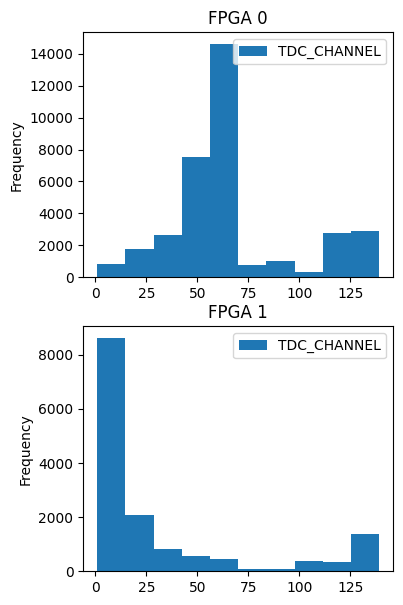

In [14]:
ax = subset.plot.hist(column=['TDC_CHANNEL'], by='FPGA',figsize=(4, 7))
ax[0].set_title("FPGA 0")
ax[1].set_title("FPGA 1")